In [1]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Serif"
import pyipmeta as ipm
import requests
import wget
import shutil
import gzip
import json

from sklearn.linear_model import LinearRegression
import numpy as np

import geoplot.crs as gcrs
import geoplot
import os
from datetime import datetime
import socket 
import sys
import netaddr

In [2]:


import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json
from dask.distributed import Client, LocalCluster


In [3]:

meta = ipm.IpMeta(providers=["pfx2as -f " + 'pfx_to_as/routeviews-rv2-20220920-1200.txt'])
rir_df = pd.read_csv('/data1/manasvini/rir.csv')

In [4]:
meta.lookup('1.1.1.0')

[{'source': 3,
  'id': 0,
  'country_code': '',
  'continent_code': '',
  'region': '',
  'city': '',
  'post_code': '',
  'lat_long': (0.0, 0.0),
  'metro_code': 0,
  'area_code': 0,
  'region_code': 0,
  'connection_speed': '',
  'asns': [13335],
  'asn_ip_count': 2425344,
  'polygon_ids': [],
  'matched_ip_count': 1}]

In [4]:
def get_files_no_pfx(dirname):
    
    files = [os.path.join(dirname, f) for f in os.listdir(dirname)]
    return files
def get_dirs(dirname):
    dirs = [os.path.join(dirname, f) for f in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, f))]
    return dirs
def get_files(dirname, pfx):
    files = [os.path.join(dirname, f) for f in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, f)) and pfx in f]
    return files

In [5]:
def asn(x):
    try:
        asninfo = meta.lookup(x)
        print(asinfo)
        if len(asninfo) == 1:
            return asninfo[0]['asns']
        elif len(asninfo) == 0:
            return []
        else:
            return [asninof[i]['asns'] for i in range(len(asninfo))]
    except:
        return []

def asn_dask(x):    
    
    #print(x)
    asninfo = meta.lookup(x)
    #print(asninfo)
    if len(asninfo) == 1:
        return ','.join([str(asn) for asn in asninfo[0]['asns']])
    elif len(asninfo) == 0:
        return ''
    else:
        return ','.join([asninfo[i]['asns'] for i in range(len(asninfo))])
    

def populate_asn_dask(df):
    return df['/24'].astype(str).apply(lambda x: asn_dask(x))
    #df['asn_str'] = df['asn'].apply(lambda x: ','.join(map(str, x)))
    #df['num_ases'] = df['asn'].apply(lambda x: len(x))
    #return df
def populate_asn(df):
    df['asn'] = df['/24'].astype(str).apply(lambda x: asn(x))
    df['asn_str'] = df['asn'].apply(lambda x: ','.join(map(str, x)))
    df['num_ases'] = df['asn'].apply(lambda x: len(x))
    return df

In [6]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, dashboard_address=':37937')  # Launches a scheduler and workers locally
client = Client(cluster) 
cluster.dashboard_link

'http://127.0.0.1:37937/status'

In [46]:
files = get_files('/data1/manasvini/censys/proto/best_survey_new_', 'parquet')
censys_ddf = dd.read_parquet(files, blocksize='200MB')

In [47]:
censys_ddf.columns

Index(['ipint', 'censys_survey_83', 'censys_survey_84', 'censys_survey_85',
       'censys_survey_86', 'censys_survey_87', 'censys_survey_88',
       'censys_survey_89', 'censys_survey_90', 'censys_survey_91', '/24'],
      dtype='object')

In [34]:
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/last10withipint/everalive'

files = list(set(get_files_no_pfx(dirname)))

ant_ddf = dd.read_parquet(get_files(dirname, 'parquet'), blocksize='20MB')


In [24]:
ant_ddf = ant_ddf.rename(columns={'/24':'/24_str'})


In [16]:
def read_ddfs(dirpath, colpfxs):
    
    merged_survey_ddfs = []
    for survey in range(83, 92):
        print(survey)
        
        surveystr = str(survey)  
        cols = [cpfx + surveystr for cpfx in colpfxs]
        merged_ddfs = [] 
        for p in range(10):

            files = get_files(dirpath +surveystr + '/' + 'part_' + str(p), 'parquet')
            merged_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')
            merged_ddfs.append(merged_ddf)

        merged_ddf = dd.concat(merged_ddfs)

        print(merged_ddf.columns)
        print(merged_ddf.count().compute())

        if len(merged_survey_ddfs) == 0:
            merged_survey_ddfs.append(merged_ddf)
        else:
            merged_survey_ddfs.append(merged_ddf[cols])

        #break
    final_merged_ddf = dd.concat(merged_survey_ddfs, axis=1, ignore_unknown_divisions=True)

    return final_merged_ddf

In [49]:

def ip2int(x):
    try:
        return netaddr.IPAddress(x).value
    except:
        return None

def int2ip24(x):
    ip =  str(netaddr.IPAddress(int(x)))
    return ip2int('.'.join(ip.split('.')[0:3]) + '.0')

def int2ip(x):
    try:
        return str(netaddr.IPAddress(int(x)))
    except:
        return None

def get_24_from_int(df):
    return df['ipint'].apply(lambda x: int2ip24(x))

In [12]:
dirpath = '/data1/manasvini/censys/proto/merged_survey_new_'
merged_ddf = read_ddfs(dirpath, ['ant_survey_', 'combined_survey_'])

83
Index(['ipint', 'ant_survey_83', 'combined_survey_83'], dtype='object')
ipint                 810872232
ant_survey_83         810872232
combined_survey_83    810872232
dtype: int64
84
Index(['ipint', 'ant_survey_84', 'combined_survey_84'], dtype='object')
ipint                 810872232
ant_survey_84         810872232
combined_survey_84    810872232
dtype: int64
85
Index(['ipint', 'ant_survey_85', 'combined_survey_85'], dtype='object')
ipint                 810872232
ant_survey_85         810872232
combined_survey_85    810872232
dtype: int64
86
Index(['ipint', 'ant_survey_86', 'combined_survey_86'], dtype='object')
ipint                 810872232
ant_survey_86         810872232
combined_survey_86    810872232
dtype: int64
87
Index(['ipint', 'ant_survey_87', 'combined_survey_87'], dtype='object')
ipint                 810872232
ant_survey_87         810872232
combined_survey_87    810872232
dtype: int64
88
Index(['ipint', 'ant_survey_88', 'combined_survey_88'], dtype='object')
ipint

In [20]:
merged_ddf['/24'] = merged_ddf.map_partitions(get_24_from_int, meta=('ipint', int))

In [17]:
dirpath = '/data1/manasvini/censys/proto/best_survey_new_'
censys_ddf = read_ddfs(dirpath, ['survey_'])

83
Index(['ipint', 'survey_83'], dtype='object')
ipint        440744296
survey_83    440744296
dtype: int64
84
Index(['ipint', 'survey_84'], dtype='object')
ipint        440744296
survey_84    440744296
dtype: int64
85
Index(['ipint', 'survey_85'], dtype='object')
ipint        440744296
survey_85    440744296
dtype: int64
86
Index(['ipint', 'survey_86'], dtype='object')
ipint        440744296
survey_86    440744296
dtype: int64
87
Index(['ipint', 'survey_87'], dtype='object')
ipint        440744296
survey_87    440744296
dtype: int64
88
Index(['ipint', 'survey_88'], dtype='object')
ipint        440744296
survey_88    440744296
dtype: int64
89
Index(['ipint', 'survey_89'], dtype='object')
ipint        440744296
survey_89    440744296
dtype: int64
90
Index(['ipint', 'survey_90'], dtype='object')
ipint        440744296
survey_90    440744296
dtype: int64
91
Index(['ipint', 'survey_91'], dtype='object')
ipint        440744296
survey_91    440744296
dtype: int64


In [38]:
censys_ddf['/24'] = censys_ddf.map_partitions(get_24_from_int, meta=('ipint', int))

In [ ]:
merged_survey_ddfs = []
for surveynum in range(83, 92):
    surveystr = str(surveynum)   
    print(surveynum)
    merged_ddfs = []
    for p in range(10):

        files = get_files('/data1/manasvini/censys/proto/merged_survey_new'+str(surveynum) + '/' + 'part_' + p, 'parquet')
        merged_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')

        merged_ddfs.append(merged_ddf)
    merged_ddf = dd.concat(merged_ddfs)
    merged_ddf['/24'] = merged_ddf['ipint'].astype(int).apply(lambda x: int2ip24(x), ,meta=('ipint', int))
    print(merged_ddf.columns)
    print(merged_ddf.count().compute())
    #if len(merged_survey_ddfs) == 0:
    merged_survey_ddfs.append(merged_ddf)
    

In [95]:
survey_cts = []
ant_24s = {}
censys_24s = {}
combined_24s= {}

In [37]:
censys_ddf['.columns']

Index(['ipint', 'survey_83', 'survey_84', 'survey_85', 'survey_86',
       'survey_87', 'survey_88', 'survey_89', 'survey_90', 'survey_91'],
      dtype='object')

In [73]:
for i in range(len(merged_survey_ddfs)):
    s = str(i + 83)
    print(s)
    survey = s
    
    ant_24 = ant_24s[survey]
    censys_24 = censys_24s[survey] 
    merged_24 = ant_24.merge(censys_24, on='/24', how='outer')
    combined_24s[survey] = merged_24
    

83
84
85
86
87
88
89
90
91


In [27]:
ant_ddf['/24'] = ant_ddf.map_partitions(get_24_from_int, meta=('ipint', int))

In [ ]:
for s in range(83, 92):
    survey = str(s)
#     if s == 84:
#         continue
    print(s)
    ant_ddf['survey_'+survey] = ant_ddf['survey_'+survey].astype(int)

ant_cols = ['survey_' + str(i) for i in range(83, 92)]

merged_cols = ['combined_survey_' + str(i) for i in range(83, 92)]
ant_24 = ant_ddf.groupby('/24')[ant_cols].sum().reset_index().compute()

In [ ]:
censys_cols = ['survey_' + str(i) for i in range(83, 92)]
#ant_24s[survey] = ant_24[ant_24['survey_'+survey]> 0]
censys_24 = censys_ddf.groupby('/24')[censys_cols].sum().reset_index().compute()
#censys_24s[survey] = censys_24[censys_24['censys_survey_'+survey]>0]
combined_24 = merged_ddf.groupby('/24')[merged_cols].sum().reset_index().compute()

In [96]:
for s in range(83, 92):
    survey = str(s)
    ant_24s[survey] = ant_24[ant_24['survey_'+survey]> 0][['survey_'+survey, '/24']]
    censys_24s[survey] = censys_24[censys_24['survey_'+survey]>0][['survey_'+survey, '/24']]
    combined_24s[survey] = combined_24[combined_24['combined_survey_'+survey]>0][['combined_survey_'+survey, '/24']]
#print('ant=', len(ant_24), 'censys=', len(censys_24), 'combined=', len(combined_24))

In [58]:
ant_24['/24_int'] = ant_24['/24'].apply(lambda x: ip2int(x))

In [59]:
ant_24 = ant_24.rename(columns={'/24':'/24_str', '/24_int':'/24'})

In [77]:
all_24s = pd.concat([ant_24['/24'], censys_24['/24'], combined_24['/24']]).drop_duplicates().to_frame()

In [78]:
all_24s['/24_str'] = all_24s['/24'].apply(lambda x: int2ip(x))

In [79]:
all_24s['asn'] = all_24s['/24_str'].apply(lambda x: asn_dask(x))

### Write out the summary dfs to disk so that we can use those instead  


In [85]:
asns_df = all_24s

In [87]:
asns_df['num_asns'] = asns_df['asn'].apply(lambda x: len(x.split(',')))
    

In [97]:
asns_df

,/24,/24_str,asn,num_asns
0,16777216,1.0.0.0,13335,1
1,16802816,1.0.100.0,18144,1
2,16803072,1.0.101.0,18144,1
3,16803328,1.0.102.0,18144,1
4,16803584,1.0.103.0,18144,1
...,...,...,...,...
5726542,3755506944,223.216.125.0,4713,1
5726543,3757062144,223.240.56.0,4134,1
5726546,3757230080,223.242.200.0,4134,1
5726547,3757267712,223.243.91.0,4134,1


In [98]:
asns_summary_df=[]

for s in range(83, 92):
    survey = str(s)
#     if s == 84:
#         continue
    print(s)
    censys_asn_df = censys_24s[str(s)]
    censys_asn_df = censys_asn_df.merge(asns_df, how='inner', on='/24') 
    #censys_24_ddf['num_asns'] = censys_24_ddf['asn'].apply(lambda x: len(x.split(',')), meta=('asn', 'str'))
    
    ant_asn_df = ant_24s[str(s)]
    ant_asn_df = ant_asn_df.merge(asns_df, how='inner', on='/24')
    print(ant_asn_df)
    antcensys_asn_df = combined_24s[str(s)]
    antcensys_asn_df = antcensys_asn_df.merge(asns_df, how='inner', on='/24')
  
    ant_ases = set(list(ant_asn_df[(ant_asn_df['num_asns']==1)&(ant_asn_df['asn']!='')]['asn']))
    censys_ases = set(list(censys_asn_df[(censys_asn_df['num_asns']==1)&(censys_asn_df['asn']!='')]['asn']))
    antcensys_ases = set(list(antcensys_asn_df[(antcensys_asn_df['num_asns']==1)&(antcensys_asn_df['asn']!='')]['asn']))
    asns_summary_df.append({'ant':ant_asn_df[ant_asn_df['num_asns']==1]['asn'].nunique(), \
                   'censys':censys_asn_df[censys_asn_df['num_asns']==1]['asn'].nunique(),\
                   'survey':str(s),\
                   'ant_censys':antcensys_asn_df[antcensys_asn_df['num_asns']==1]['asn'].nunique()})
    ant_24s[str(s)] = ant_asn_df
    censys_24s[str(s)] = censys_asn_df


83
         survey_83         /24        /24_str    asn  num_asns
0              255    16777216        1.0.0.0  13335         1
1               12    16802816      1.0.100.0  18144         1
2               13    16803072      1.0.101.0  18144         1
3                8    16803328      1.0.102.0  18144         1
4                6    16803584      1.0.103.0  18144         1
...            ...         ...            ...    ...       ...
5065896          4  3758095360  223.255.252.0  58519         1
5065897          5  3758095616  223.255.253.0  58519         1
5065898          5  3758095872  223.255.254.0  55415         1
5065899         23  3758038016   223.255.28.0                1
5065900          1  3758031616    223.255.3.0                1

[5065901 rows x 5 columns]
84
         survey_84         /24        /24_str    asn  num_asns
0              254    16777216        1.0.0.0  13335         1
1               12    16802816      1.0.100.0  18144         1
2               16   

In [109]:
asn_summary_df = pd.DataFrame(asns_summary_df)
asn_summary_df['survey'] = asn_summary_df['survey'].astype(int) - 82

In [105]:
host_data = []
block_data = []

for s in range(83, 92):
    survey = str(s)
    ant_blks = ant_24s[survey]['/24'].count()
    censys_blks = censys_24s[survey]['/24'].count()
    combined_blks = combined_24s[survey]['/24'].count()
    ant_hosts = ant_24s[survey]['survey_'+survey].sum()
    censys_hosts = censys_24s[survey]['survey_'+survey].sum()
    combined_hosts = combined_24s[survey]['combined_survey_'+survey].sum()
    
    host_data.append({'survey':s -82, 'ant_hosts':ant_hosts, 'censys_hosts':censys_hosts, 'antcensys_hosts':combined_hosts})
    block_data.append({'survey':s -82, 'ant_blks':ant_blks, 'censys_blks':censys_blks, 'antcensys_blks':combined_blks})
    

In [155]:

overlap_asn = []
for s in range(83, 92):
    survey = str(s)
    ant_asns = ant_24s[survey]['asn'].tolist()
    censys_asns = censys_24s[survey]['asn'].tolist()
    overlap_asn.append({'survey':survey, 'overlap':len(set(ant_asns).intersection(set(censys_asns))), 'total':len(set(ant_asns).union(set(censys_asns)))})
    

In [157]:
overlap_df = pd.DataFrame(overlap_asn)
overlap_df['frac'] = overlap_df['overlap']/overlap_df['total']
overlap_df['frac'].mean()

0.9136126442597943

In [122]:
COLORS = ['#0f4d5c','#846aa5', '#ff837a']

In [106]:
blk_summary_df = pd.DataFrame(block_data)
host_summary_data = pd.DataFrame(host_data)

In [ ]:
blk_summary_df['ant_m'] = blk_summary_df['ant_blks']/1e6
blk_summary_df['censys_m'] = blk_summary_df['censys_blks']/1e6
blk_summary_df['ant_censys_m'] = blk_summary_df['antcensys_blks']/1e6

In [148]:
(blk_summary_df['antcensys_blks'] - blk_summary_df['ant_blks']).mean()

293909.3333333333

In [160]:
blk_summary_df

,survey,ant_blks,censys_blks,antcensys_blks,ant_m,censys_m,ant_censys_m,diff
0,1,5065901,4546581,5405358,5.065901,4.546581,5.405358,339457
1,2,5085238,4510084,5402832,5.085238,4.510084,5.402832,317594
2,3,5091179,4489528,5375706,5.091179,4.489528,5.375706,284527
3,4,5122058,4504249,5444682,5.122058,4.504249,5.444682,322624
4,5,5102003,4459979,5371796,5.102003,4.459979,5.371796,269793
5,6,5119014,4541182,5393130,5.119014,4.541182,5.393130,274116
6,7,5116218,4534924,5395971,5.116218,4.534924,5.395971,279753
7,8,5124031,4513732,5396217,5.124031,4.513732,5.396217,272186
8,9,5124796,4527860,5409930,5.124796,4.527860,5.409930,285134


In [158]:
blk_summary_df['diff'] = blk_summary_df['antcensys_blks'] - blk_summary_df['ant_blks']
blk_summary_df['diff'].mean()

293909.3333333333

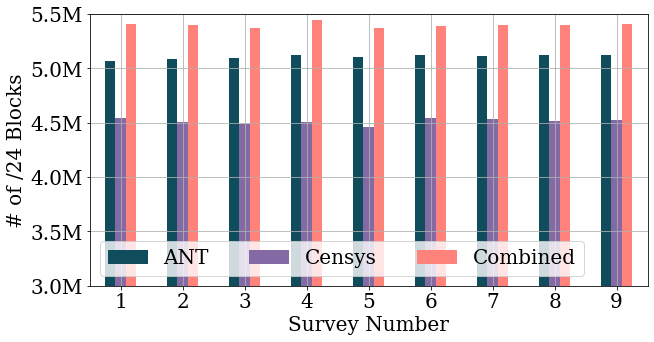

In [161]:

fig, ax = plt.subplots(figsize=(10, 5))

ax = blk_summary_df.set_index('survey')[['ant_m', 'censys_m', 'ant_censys_m']].plot.bar(ax=ax,color=COLORS, grid=True)

ax.set_ylim(3, 5.5)
ax.set_xlabel('Survey Number', fontsize=20)
ax.set_ylabel('# of /24 Blocks', fontsize=20)
ax.yaxis.set_major_formatter('{x:1.1f}M')
ax.legend(['ANT', 'Censys', 'Combined'], fontsize=20, ncol=3, loc='lower left')
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x.2f}'))
plt.savefig('figs_pam/ant_censys_blk_time_new.pdf', bbox_inches='tight')

In [ ]:
asn_summary_df['ant_k'] = asn_summary_df['ant']/1000
asn_summary_df['censys_k'] = asn_summary_df['censys']/1000
asn_summary_df['ant_censys_k'] = asn_summary_df['ant_censys']/1000

In [159]:
asn_summary_df

,ant,censys,survey,ant_censys,ant_k,censys_k,ant_censys_k
0,64848,63594,1,67106,64.848,63.594,67.106
1,65750,64250,2,67988,65.750,64.250,67.988
2,66290,64929,3,68436,66.290,64.929,68.436
3,67188,65354,4,69404,67.188,65.354,69.404
4,67540,66555,5,69779,67.540,66.555,69.779
5,68131,67225,6,70505,68.131,67.225,70.505
6,68745,67653,7,71088,68.745,67.653,71.088
7,69317,67997,8,71684,69.317,67.997,71.684
8,69188,67716,9,71554,69.188,67.716,71.554


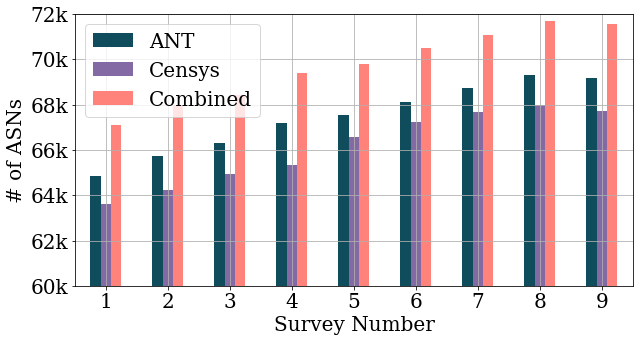

In [145]:

fig, ax = plt.subplots(figsize=(10, 5))

ax = asn_summary_df.set_index('survey')[['ant_k', 'censys_k', 'ant_censys_k']].plot.bar(ax=ax,color=COLORS, grid=True)

ax.set_ylim(60, 72)
ax.set_xlabel('Survey Number', fontsize=20)
ax.set_ylabel('# of ASNs', fontsize=20)
ax.yaxis.set_major_formatter('{x:1.0f}k')
ax.legend(['ANT', 'Censys', 'Combined'], fontsize=20, ncol=1)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x.2f}'))
plt.savefig('figs_pam/ant_censys_asn_time_new.pdf', bbox_inches='tight')

## Read summary data from disk

In [7]:
survey_cts = []
ant_24s = {}
censys_24s = {}
combined_24s= {}
for s in range(83, 92):
    survey = str(s)
    if s == 84:
        continue
    print(s)
    ant_24s[survey] = pd.read_csv('/data1/manasvini/ant_censys_processed/ant_survey_'+survey + '.csv')
    censys_24s[survey] = pd.read_csv('/data1/manasvini/ant_censys_processed/censys_survey_'+survey + '.csv')
    combined_24s[survey]= pd.read_csv('/data1/manasvini/ant_censys_processed/ant_censys_survey_'+survey + '.csv')

83
85
86
87
88
89


/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


90
91


In [8]:
num_24_df = []
for i in range(len(ant_24s)):
    s = i + 83
    if s >= 84:
        s += 1
    censys_24_ddf = dd.from_pandas(censys_24s[str(s)], npartitions=20)
    ant_24_ddf = dd.from_pandas(ant_24s[str(s)], npartitions=20)
    merged_df = dd.concat([ant_24_ddf['/24'],censys_24_ddf['/24']]).drop_duplicates().compute()
    #merged_24_dfs[str(s)] = merged_df
    num_24_df.append({'ant': len(ant_24s[str(s)]), 'censys':len(censys_24s[str(s)]), 'survey_num': s, 'ANT+Censys':len(merged_df)})

In [9]:
num_24_df = pd.DataFrame(num_24_df)
num_24_df.set_index('survey_num', inplace=True)

## /24s discovered in ANT and Censys over time  
- Find unique /24 blocks in ANT, Censys and ANT + Censys combined
- Repeat for every survey (Starting Nov 2020 up until Dec 2022)
- Adding Censys probes adds about 0.4 million unique /24s in each survey

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = num_24_df.plot.bar(ax=ax)
ax.set_ylim(4e6, 6e6)
ax.set_xlabel('Survey Number', fontsize=20)
ax.set_ylabel('# of /24s', fontsize=20)
ax.legend(['ANT /24', 'Censys /24', 'ANT + Censys /24'], fontsize=15, ncol=3)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
plt.savefig('ant_censys_24_time_new.pdf', bbox_inches='tight')

## AS level summary stats  
- Find # of unique ASes in each dataset across surveys

In [10]:
asns_df = []
for s in range(83, 92):
    survey = str(s)
    if s == 84:
        continue
    print(s)
    censys_asn_df = censys_24s[str(s)]
    #censys_asn_df = censys_asn_df.merge(asn_df, how='inner', on='/24') 
    #censys_24_ddf['num_asns'] = censys_24_ddf['asn'].apply(lambda x: len(x.split(',')), meta=('asn', 'str'))
    
    ant_asn_df = ant_24s[str(s)]
    #ant_asn_df = ant_asn_df.merge(asn_df, how='inner', on='/24')

  
    ant_ases = set(list(ant_asn_df[(ant_asn_df['num_asns']==1)&(ant_asn_df['asn']!='')]['asn']))
    censys_ases = set(list(censys_asn_df[(censys_asn_df['num_asns']==1)&(censys_asn_df['asn']!='')]['asn']))
    asns_df.append({'ant':ant_asn_df[ant_asn_df['num_asns']==1]['asn'].nunique(), \
                   'censys':censys_asn_df[censys_asn_df['num_asns']==1]['asn'].nunique(),\
                   'survey':str(s-82),\
                   'ant_censys':len(ant_ases.union(censys_ases))})
    #ant_24s[str(s)] = ant_asn_df
    #censys_24s[str(s)] = censys_asn_df

83
85
86
87
88
89
90
91


,ant,censys,ant_censys
survey,,,
1,64847,64686,67204
3,66289,66574,68472
4,67187,67790,69569
5,67539,68334,69842
6,68130,69219,70623
7,68782,69538,71206
8,69316,70289,71906
9,69187,69986,71647


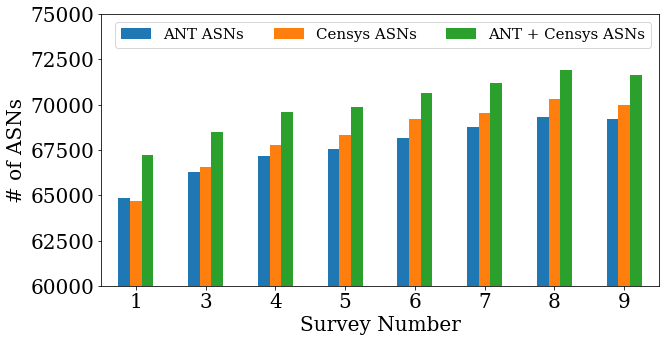

In [11]:
asns_df = pd.DataFrame(asns_df)
asns_df.set_index('survey', inplace=True)
fig, ax = plt.subplots(figsize=(10, 5))
ax = asns_df.plot.bar(ax=ax)
ax.set_ylim(6e4, 7.5e4)
ax.set_xlabel('Survey Number', fontsize=20)
ax.set_ylabel('# of ASNs', fontsize=20)
ax.legend(['ANT ASNs', 'Censys ASNs', 'ANT + Censys ASNs'], fontsize=15, ncol=3)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
#plt.savefig('figs_analysis_2/ant_censys_asn_time.png', bbox_inches='tight')

In [12]:
asn_cts = []
asn_merged_dfs = []
for survey in ant_24s:
    asn_ant_df = ant_24s[survey]
    #asn_ant_df.rename(columns={'asn_x':'asn'}, inplace=True)
    asn_censys_df = censys_24s[survey]
    
    asn_ant_censys_df = dd.concat([asn_ant_df, asn_censys_df]).groupby(['asn', '/24']).count().fillna(0).compute().reset_index()
    asn_ant_censys_both = asn_ant_censys_df[(asn_ant_censys_df['survey_'+survey]==1) &\
                                            (asn_ant_censys_df['censys_survey_'+survey]==1)].groupby('asn')['/24'].count().reset_index()
    
    asn_ant = asn_ant_censys_df[(asn_ant_censys_df['survey_'+survey]!=0) &\
                                            (asn_ant_censys_df['censys_survey_'+survey]==0)].groupby('asn')['/24'].count().reset_index()
    
    asn_censys = asn_ant_censys_df[(asn_ant_censys_df['survey_'+survey]==0) &\
                                            (asn_ant_censys_df['censys_survey_'+survey]!=0)].groupby('asn')['/24'].count().reset_index()
    
    asn_merged_df = asn_ant_censys_both.merge(asn_ant, on='asn', how='inner')
    asn_merged_df.rename(columns={'/24_x':'both /24', '/24_y':'ant /24'}, inplace=True)
    asn_merged_df = asn_merged_df.merge(asn_censys, on='asn', how='inner').rename(columns={'/24':'censys /24'})
    print(survey, len(asn_merged_df))
    asn_merged_df = asn_merged_df[asn_merged_df['asn']!='']
    asn_merged_df['total'] = asn_merged_df['both /24'] + asn_merged_df['ant /24'] + asn_merged_df['censys /24']

    asn_merged_df['both /24 %'] = 100 * asn_merged_df['both /24'] / asn_merged_df['total']
    
    asn_merged_df['ant /24 %'] = 100 * asn_merged_df['ant /24'] / asn_merged_df['total']
    
    asn_merged_df['censys /24 %'] = 100 * asn_merged_df['censys /24'] / asn_merged_df['total']
    
    asn_merged_dfs.append(asn_merged_df)
    asn_cts.append({'survey':survey, 'both':asn_merged_df['both /24'].sum(), \
                   'ant': asn_merged_df['ant /24'].sum(), 'censys':asn_merged_df['censys /24'].sum()}) 
    

83 7516
85 5929
86 6493
87 5740
88 5926
89 5833
90 6232
91 5837


In [13]:
asn_cts

[{'survey': '83', 'both': 3944280, 'ant': 627555, 'censys': 324137},
 {'survey': '85', 'both': 3913224, 'ant': 556606, 'censys': 247832},
 {'survey': '86', 'both': 4009044, 'ant': 551226, 'censys': 283909},
 {'survey': '87', 'both': 3857833, 'ant': 591315, 'censys': 254783},
 {'survey': '88', 'both': 3959493, 'ant': 528293, 'censys': 261208},
 {'survey': '89', 'both': 3965907, 'ant': 528315, 'censys': 270512},
 {'survey': '90', 'both': 3982758, 'ant': 579369, 'censys': 282549},
 {'survey': '91', 'both': 3933492, 'ant': 539724, 'censys': 270429}]

In [ ]:
# asn_cts_df = pd.DataFrame(asn_cts)
# asn_cts_df.set_index('survey', inplace=True)
# fig, ax = plt.subplots(figsize=(10, 4))
# ax = asn_cts_df.plot.bar(ax=ax)
# #ax.set_ylim(3e6, 7.5e4)
# ax.set_xlabel('Survey Number', fontsize=20)
# ax.set_ylabel('# of /24s in common ASNs', fontsize=20)
# ax.legend(['ANT + Censys /24s', 'ANT ASNs', 'Censys ASNs'], fontsize=15, ncol=3)
# ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
# plt.savefig('figs_analysis_2/ant_censys_asn_24_time.png', bbox_inches='tight')

## Common /24s within ASes  
- Find /24s common to ASes in both datasets
- CDf of % of common ASes across all ASes

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
for df in asn_merged_dfs:
    df['both /24 %'] = df['both /24 %'].astype(int)
    df['ant /24 %'] = df['ant /24 %'].astype(int)
    df['censys /24 %'] = df['censys /24 %'].astype(int)
    asn_ct_24_df = df.groupby('both /24 %')['asn'].count().reset_index()
    asn_ct_24_df['cumsum'] = asn_ct_24_df['asn'].cumsum()
    asn_ct_24_df['frac'] = asn_ct_24_df['cumsum'] / asn_ct_24_df['cumsum'].max()
    ax= asn_ct_24_df.plot.line(x='both /24 %', y='frac', ax =ax)
ax.legend(['survey '+ str(i) for i in range(1, len(asn_merged_dfs)+1)], fontsize=15, ncol=2)
ax.set_xlabel('% of /24s common to ANT and Censys', fontsize=20)
ax.set_ylabel('Fraction of ASes', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('figs_analysis_2/ant_censys_common_asn_cdf.png', bbox_inches='tight')

## Which ASes have large number of /24s unique to each dataset?  
- Who are the ASes? 
- What is the size of their customer cone?
- Calculate /24s common to ANT and Censys for each AS  
- Group ASes by % of /24s common to ANT and Censys  
- Plot the mean # of prefixes against the number of common /24s

In [ ]:
asrank_df = pd.read_csv('/data1/manasvini/asrank/asinfo.csv')

In [ ]:
ctr = 0
for df in asn_merged_dfs:
    fig, ax = plt.subplots(figsize=(15,6))
    tmpdf = df[df['asn'].str.contains(',')==False].reset_index()

    tmpdf['asn'] = tmpdf['asn'].astype(int)
    tmpdf['both /24 %'] = tmpdf['both /24 %'].astype(int) 
    merged_asrank_df = tmpdf.merge(asrank_df, on='asn', how='inner')
    #pfx_mean_df = merged_asrank_df.groupby('both /24 %')['prefixes'].mean().reset_index()
    merged_asrank_df['bin'] = '<= ' + ((merged_asrank_df['both /24 %']/10).astype(int) * 10).astype(str) 
    
    merged_asrank_df.boxplot('prefixes', by='bin', ax=ax, showfliers=False)
    ax.set_xlabel('% of /24s common to ANT and Censys in AS', fontsize=20)
    ax.set_ylabel('Mean # of prefixes for AS', fontsize=20)
    ax.tick_params(axis='x', which='major', labelsize=15, rotation=0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ctr += 1
    #plt.savefig('figs_analysis_2/pfx_as_24_survey_'+str(ctr) + '.png', bbox_inches='tight')
    #print(merged_asrank_df['addresses'].mean(), merged_asrank_df['cone_asns'].mean(), merged_asrank_df['prefixes'].mean())

In [ ]:
ctr = 0
for df in asn_merged_dfs:
    fig, ax = plt.subplots(figsize=(15,7))
    tmpdf = df[df['asn'].str.contains(',')==False].reset_index()

    tmpdf['asn'] = tmpdf['asn'].astype(int)
    tmpdf['both /24 %'] = tmpdf['both /24 %'].astype(int) 
    merged_asrank_df = tmpdf.merge(asrank_df, on='asn', how='inner')
    #pfx_mean_df = merged_asrank_df.groupby('both /24 %')['addresses'].mean().reset_index()
    merged_asrank_df['bin'] = '<= ' + ((merged_asrank_df['both /24 %']/10).astype(int) * 10).astype(str) 
    
    #pfx_mean_df.groupby('bin')['addresses'].mean().plot.bar(x='bin', y='prefixes', ax=ax)
    pfx_mean_df.boxplot('addresses', by='bin', ax=ax)
    
    ax.set_xlabel('% of /24s common to ANT and Censys in AS', fontsize=20)
    ax.set_ylabel('# of addresses for AS', fontsize=20)
    ax.tick_params(axis='x', which='major', labelsize=15, rotation=0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ctr += 1
    #plt.tight_layout()
    #plt.savefig('figs_analysis_2/address_as_24_survey_'+str(ctr) + '_boxplot.png', bbox_inches='tight')
    #print(merged_asrank_df['addresses'].mean(), merged_asrank_df['cone_asns'].mean(), merged_asrank_df['prefixes'].mean())

## Trinocular  Data Generation
- Compute block availability scores. Let's take one survey for the time being and compute block availability like so: sum of individual host availability (0=no response, 1 =response) divided by block size.  
- Then plot a CDF of block availability scores  

## Save per survey availability stats

In [21]:

def ip2int(x):
    return netaddr.IPAddress(x).value

def int2ip24(x):
    ip =  str(netaddr.IPAddress(int(x)))
    return ip2int('.'.join(ip.split('.')[0:3]) + '.0')

def get24fromint(x):
    return   str(netaddr.IPAddress(int(x)))
def get_24_from_int(df):
    return df['ipint'].apply(lambda x: int2ip24(x))

In [9]:
get24fromint(1000000)

'0.15.66.64'

In [10]:
block_availability_dfs = []
BLOCK_SIZE = 256

## Save A(E(b)) for ANT

In [11]:
merged_survey_ddfs = []
for surveynum in range(88, 92):
    surveystr = str(surveynum)   
    print(surveynum)
    merged_ddfs = []
    for p in range(10):

        files = get_files('/data1/manasvini/ant_merged_new/ant_merged_'+str(p) + '/' + 'survey_' + surveystr, 'parquet')
        merged_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')
        merged_ddfs.append(merged_ddf)
    merged_ddf = dd.concat(merged_ddfs)
    print(merged_ddf.columns)
    #print(merged_ddf.head(10))
    if len(merged_survey_ddfs) == 0:
        merged_survey_ddfs.append(merged_ddf)
    else:
        merged_survey_ddfs.append(merged_ddf['survey_'+surveystr])

88
Index(['ipint', 'survey_88'], dtype='object')
89
Index(['ipint', 'survey_89'], dtype='object')
90
Index(['ipint', 'survey_90'], dtype='object')
91
Index(['ipint', 'survey_91'], dtype='object')


In [ ]:
def set_max_val(x):
    if x > 1:
        return 1
    return x

In [12]:
ant_merged_ddf = dd.concat(merged_survey_ddfs, axis=1, ignore_unknown_divisions=True)
# ant_censys_merged_ddf.columns
for c in ['survey_88', 'survey_89', 'survey_90', 'survey_91']:
    ant_merged_ddf[c] = ant_merged_ddf[c].apply(lambda x: set_max_val(x), meta=(c, 'int64'))    

In [16]:
ant_merged_ddf.count().compute()

ipint        820140651
survey_88    820140651
survey_89    820140651
survey_90    820140651
survey_91    820140651
/24          820140651
dtype: int64

In [15]:
ant_merged_ddf['/24']  =  ant_merged_ddf.map_partitions(get_24_from_int).astype(int)

In [17]:
os.makedirs('/data1/manasvini/ant_intermediate_new/aeb_last4', exist_ok=True)
ant_merged_ddf.to_parquet('/data1/manasvini/ant_intermediate_new/aeb_last4',overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"} )

In [18]:
files = get_files('/data1/manasvini/ant_intermediate_new/aeb_last4', 'parquet')
ant_merged_ddf = dd.read_parquet(files, blocksize='20MB')

In [19]:
ant_merged_ddf.head(10)

,ipint,survey_88,survey_89,survey_90,survey_91,/24
0,16777220,1,1,1,1,16777216
1,16777230,1,1,1,1,16777216
2,16777240,1,1,1,1,16777216
3,16777250,1,1,1,1,16777216
4,16777260,1,1,1,1,16777216
5,16777270,1,1,1,1,16777216
6,16777280,1,1,1,1,16777216
7,16777290,1,1,1,1,16777216
8,16777300,1,1,1,1,16777216
9,16777310,1,1,1,1,16777216


In [20]:
#files = get_files('/data1/manasvini/ant_intermediate_new/aeb_last4', 'parquet')
#ant_merged_ddf = dd.read_parquet(files, blocksize='50MB')
ant_merged_ddf['aeb'] = (ant_merged_ddf['survey_88'] + ant_merged_ddf['survey_89'] + ant_merged_ddf['survey_90'] + ant_merged_ddf['survey_91'])/4.0
ant_merged_ddf['/24']  =  ant_merged_ddf.map_partitions(get_24_from_int)
os.makedirs('/data1/manasvini/ant_intermediate_new/aeb', exist_ok=True)
ant_merged_ddf[['ipint', 'aeb', '/24']].to_parquet('/data1/manasvini/ant_intermediate_new/aeb', overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"})


## Save A(E(b)) computation for merged dataset

In [9]:
merged_survey_ddfs = []
for surveynum in range(88, 92):
    surveystr = str(surveynum)   
    print(surveynum)
    merged_ddfs = []
    for p in range(10):

        files = get_files('/data1/manasvini/ant_censys_merged_new/ant_censys_merged_'+str(p) + '/' + 'survey_' + surveystr, 'parquet')
        merged_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')
        merged_ddfs.append(merged_ddf)
    merged_ddf = dd.concat(merged_ddfs)
    print(merged_ddf.columns)
    print(merged_ddf.count().compute())
    if len(merged_survey_ddfs) == 0:
        merged_survey_ddfs.append(merged_ddf)
    else:
        merged_survey_ddfs.append(merged_ddf['survey_'+surveystr].to_frame())
    

88
Index(['ipint', 'survey_88'], dtype='object')
ipint        820140651
survey_88    820140651
dtype: int64
89
Index(['ipint', 'survey_89'], dtype='object')
ipint        820140651
survey_89    820140651
dtype: int64
90
Index(['ipint', 'survey_90'], dtype='object')
ipint        820140651
survey_90    820140651
dtype: int64
91
Index(['ipint', 'survey_91'], dtype='object')
ipint        820140651
survey_91    820140651
dtype: int64


In [10]:
ant_censys_merged_ddf = dd.concat(merged_survey_ddfs, axis=1, ignore_unknown_divisions=True)
# ant_censys_merged_ddf.columns


In [11]:
print(len(merged_survey_ddfs))

4


In [12]:
for ddf in merged_survey_ddfs:
    print(ddf.count().compute())

ipint        820140651
survey_88    820140651
dtype: int64
survey_89    820140651
dtype: int64
survey_90    820140651
dtype: int64
survey_91    820140651
dtype: int64


In [25]:
ant_censys_merged_ddf.columns

Index(['ipint', 'survey_88', 'survey_89', 'survey_90', 'survey_91'], dtype='object')

In [26]:


for c in ['survey_88', 'survey_89', 'survey_90', 'survey_91']:
    ant_censys_merged_ddf[c] = ant_censys_merged_ddf[c].apply(lambda x: set_max_val(x), meta=(c, 'int64'))
#ant_censys_merged_ddf['aeb'] = ant_censys_merged_ddf['survey_88'] + ant_censys_merged_ddf['survey_89'] + ant_censys_merged_ddf['survey_90'] + ant_censys_merged_ddf['survey_91']
#ant_censys_merged_ddf[['ipint', 'aeb']].repartition(partition_size='10MB').to_parquet('/data1/manasvini/ant_censys_merged/aeb', overwrite=True, write_index=False)


In [27]:
ant_censys_merged_ddf.dtypes

ipint        int64
survey_88    int64
survey_89    int64
survey_90    int64
survey_91    int64
dtype: object

In [28]:
os.makedirs('/data1/manasvini/ant_censys_intermediate_new/aeb_last4', exist_ok=True)
ant_censys_merged_ddf.to_parquet('/data1/manasvini/ant_censys_intermediate_new/aeb_last4',overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"} )

In [29]:
files = get_files('/data1/manasvini/ant_censys_intermediate_new/aeb_last4', 'parquet')
ant_censys_merged_ddf = dd.read_parquet(files, blocksize='20MB')

In [30]:
ant_censys_merged_ddf.count().compute()

ipint        820140651
survey_88    820140651
survey_89    820140651
survey_90    820140651
survey_91    820140651
dtype: int64

In [31]:
files = get_files('/data1/manasvini/ant_censys_intermediate_new/aeb_last4', 'parquet')
ant_censys_merged_ddf = dd.read_parquet(files, blocksize='50MB')
ant_censys_merged_ddf['aeb'] = (ant_censys_merged_ddf['survey_88'] + ant_censys_merged_ddf['survey_89'] + ant_censys_merged_ddf['survey_90'] + ant_censys_merged_ddf['survey_91'])/4.0
ant_censys_merged_ddf['/24']  =  ant_censys_merged_ddf.map_partitions(get_24_from_int)
os.makedirs('/data1/manasvini/ant_censys_intermediate_new/aeb', exist_ok=True)
ant_censys_merged_ddf[['ipint', 'aeb', '/24']].to_parquet('/data1/manasvini/ant_censys_merged_new/aeb', overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"})


## Save A(E(b)) for merged Censys (best) dataset

In [30]:
merged_survey_ddfs = []
for surveynum in range(88, 92):
    surveystr = str(surveynum)   
    print(surveynum)
    merged_ddfs = []
    for p in range(10):

        files = get_files('/data1/manasvini/censys/proto/merged_survey_new_'+str(surveystr) + '/part_' + str(p) ,  'parquet')
        merged_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')
        merged_ddfs.append(merged_ddf)
    merged_ddf = dd.concat(merged_ddfs).set_index('ipint')
    #print(merged_ddf.columns)
    #print(merged_ddf.count().compute())
    if len(merged_survey_ddfs) == 0:
        merged_survey_ddfs.append(merged_ddf)
    else:
        merged_survey_ddfs.append(merged_ddf[['ant_survey_'+surveystr, 'combined_survey_'+surveystr]])
    

88
89
90
91


In [36]:
ant_censys_best_merged_ddf = dd.concat(merged_survey_ddfs, axis=1, ignore_unknown_divisions=True)


In [37]:
ant_censys_best_merged_ddf = ant_censys_best_merged_ddf.reset_index()

In [40]:
ant_censys_best_merged_ddf

,ipint,ant_survey_88,combined_survey_88,ant_survey_89,combined_survey_89,ant_survey_90,combined_survey_90,ant_survey_91,combined_survey_91
npartitions=2955,,,,,,,,,
,int64,float64,int64,float64,int64,float64,int64,float64,int64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [41]:
ant_censys_best_merged_ddf['/24']  =  ant_censys_best_merged_ddf.map_partitions(get_24_from_int)

In [43]:
ant_censys_best_merged_ddf['aeb_combined'] = (ant_censys_best_merged_ddf['combined_survey_88'] + ant_censys_best_merged_ddf['combined_survey_89'] + ant_censys_best_merged_ddf['combined_survey_90'] + ant_censys_best_merged_ddf['combined_survey_91'])/4.0
ant_censys_best_merged_ddf['aeb_ant'] = (ant_censys_best_merged_ddf['ant_survey_88'] + ant_censys_best_merged_ddf['ant_survey_89'] + ant_censys_best_merged_ddf['ant_survey_90'] + ant_censys_best_merged_ddf['ant_survey_91'])/4.0

os.makedirs('/data1/manasvini/censys/proto/aeb', exist_ok=True)
ant_censys_best_merged_ddf[['ipint', 'aeb_ant', 'aeb_combined', '/24']].to_parquet('/data1/manasvini/censys/proto/aeb', overwrite=True, write_index=False, compression={"name": "gzip", "values": "lz4"})


In [44]:
client.shutdown()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
